In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

In [4]:
train['image_id']=train['image_id']+'.jpg'

In [5]:
train

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0
...,...,...,...,...,...
1816,Train_1816.jpg,0,0,0,1
1817,Train_1817.jpg,1,0,0,0
1818,Train_1818.jpg,1,0,0,0
1819,Train_1819.jpg,0,0,1,0


In [6]:
im_size = 512

In [7]:
labels = train.loc[:, 'healthy':].to_numpy()

In [8]:
train_images, valid_images, train_labels, valid_labels = train_test_split(train, labels, random_state=2020, test_size=0.1, stratify=labels)

In [9]:
labels = 0
images = 0

In [10]:
num_classes = 4

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    shear_range=0.1,
    rescale=1/255,    
    brightness_range=[0.5, 1.5],
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,)

Using TensorFlow backend.


In [12]:
train_generator = train_datagen.flow_from_dataframe(
    train_images,
    directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
    x_col="image_id", 
    y_col=['healthy','multiple_diseases','rust','scab'], 
    target_size=(im_size, im_size), 
    class_mode='raw',
    subset='training',
    batch_size=16)

Found 1638 validated image filenames.


In [13]:
valid_generator = train_datagen.flow_from_dataframe(
    valid_images,
    directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
    x_col="image_id", 
    y_col=['healthy','multiple_diseases','rust','scab'], 
    target_size=(im_size, im_size), 
    class_mode='raw',
    batch_size=16)

Found 183 validated image filenames.


In [14]:
from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import tensorflow as tf

# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

29089792/29084464 [==============================] - 1s 0us/step


In [15]:
layers_count = len(model.layers)

for layer in model.layers[:(layers_count // 2)]:
    layer.trainable = False

In [16]:
from keras.optimizers import SGD
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [17]:
import keras
from keras.callbacks import ReduceLROnPlateau

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

filepath = 'best_weights.hdf5'

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto")

In [18]:
#batch_size = 64
#epochs = 50

history = model.fit_generator(train_generator,
                    steps_per_epoch=10,
                    epochs=90,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.000001), model_checkpoint],
                    validation_data=valid_generator,
                    validation_steps=10,
                    verbose=1)

Epoch 1/90
10/10 [==============================] - 290s 29s/step - loss: 0.9839 - auc: 0.7733 - val_loss: 10.7373 - val_auc: 0.7383
Epoch 2/90
10/10 [==============================] - 257s 26s/step - loss: 0.5682 - auc: 0.7141 - val_loss: 9.3288 - val_auc: 0.7173
Epoch 3/90
10/10 [==============================] - 252s 25s/step - loss: 0.3935 - auc: 0.7220 - val_loss: 27.8502 - val_auc: 0.7189
Epoch 4/90
10/10 [==============================] - 241s 24s/step - loss: 0.4813 - auc: 0.7195 - val_loss: 27.9086 - val_auc: 0.7155
Epoch 5/90
10/10 [==============================] - 252s 25s/step - loss: 0.4184 - auc: 0.7169 - val_loss: 21.6297 - val_auc: 0.7137
Epoch 6/90
10/10 [==============================] - 253s 25s/step - loss: 0.4371 - auc: 0.7164 - val_loss: 22.0676 - val_auc: 0.7135
Epoch 7/90
10/10 [==============================] - 260s 26s/step - loss: 0.2562 - auc: 0.7168 - val_loss: 14.1782 - val_auc: 0.7176
Epoch 8/90
10/10 [==============================] - 251s 25s/step - lo

In [19]:
model.load_weights(filepath)

In [20]:
scores_train = model.evaluate_generator(train_generator, 100, verbose=1)
print('Training auc:', scores_train[1])

100/100 [==============================] - 1215s 12s/step
Training auc: 0.9366286396980286


In [21]:
scores = model.evaluate_generator(valid_generator, 100, verbose=1)
print('Validation auc:', scores[1])

100/100 [==============================] - 1161s 12s/step
Validation auc: 0.9370340704917908


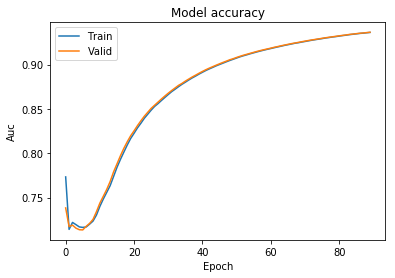

In [22]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model accuracy')
plt.ylabel('Auc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

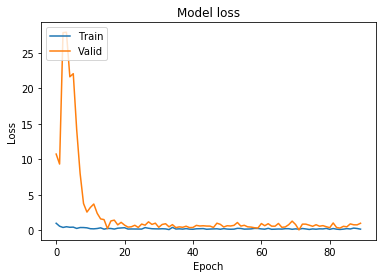

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [24]:
test = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')

In [25]:
test['image_id'] = test['image_id'] + '.jpg'

In [26]:
test_generator = train_datagen.flow_from_dataframe(
    test,
    directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',
    x_col="image_id", 
    y_col=None, 
    target_size=(im_size, im_size), 
    class_mode=None,
    batch_size=16,
    shuffle=False)

Found 1821 validated image filenames.


In [27]:
submission = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')

In [28]:
submission.loc[:, 'healthy':] = model.predict(test_generator, verbose=1)

114/114 [==============================] - 1389s 12s/step


In [29]:
submission.to_csv('submission.csv', index=False)